[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


Tech Stocks Portfolio Weights: [0.09624164 0.002603   0.00121168 0.44185799 0.45808569]
Diverse Assets Portfolio Weights: [0.0120477  0.00306485 0.17483639 0.0442213  0.76582975]


[*******************   40%                       ]  2 of 5 completed

High Dividend Yield Portfolio Weights: [0.22094929 0.37221334 0.38695754 0.01659741 0.00328242]
Tech Stocks Portfolio Value at Risk (VaR): 0.035668502884203146
Tech Stocks Portfolio Conditional Value at Risk (CVaR): -0.002131794583693775
Diverse Assets Portfolio Value at Risk (VaR): 0.02049085174479768
Diverse Assets Portfolio Conditional Value at Risk (CVaR): -0.0006085398291570073
High Dividend Yield Portfolio Value at Risk (VaR): 0.016047364280174232
High Dividend Yield Portfolio Conditional Value at Risk (CVaR): -0.0006542684829889205
Scenario Analysis Results for Tech Stocks Portfolio:
Bull Market: Return = 0.17, Volatility = 0.46
Bear Market: Return = 0.11, Volatility = 0.30
Stagnant Market: Return = 0.14, Volatility = 0.38
Scenario Analysis Results for Diverse Assets Portfolio:
Bull Market: Return = 0.57, Volatility = 0.31
Bear Market: Return = 0.38, Volatility = 0.21
Stagnant Market: Return = 0.48, Volatility = 0.26
Scenario Analysis Results for High Dividend Yield Portfolio:
B

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


Tech Stocks Portfolio Backtest Volatility: 0.38703954317456524
Tech Stocks Portfolio Backtest Sharpe Ratio: 0.00926891385813731
Tech Stocks Portfolio Max Drawdown: -0.3886992813677002
Diverse Assets Portfolio Backtest Volatility: 0.18184884770115453
Diverse Assets Portfolio Backtest Sharpe Ratio: 0.0011055199828100526
Diverse Assets Portfolio Max Drawdown: -1.8232852476175159
High Dividend Yield Portfolio Backtest Volatility: 0.12580519166832047
High Dividend Yield Portfolio Backtest Sharpe Ratio: 0.00014590873649972198
High Dividend Yield Portfolio Max Drawdown: -46.09673438543678


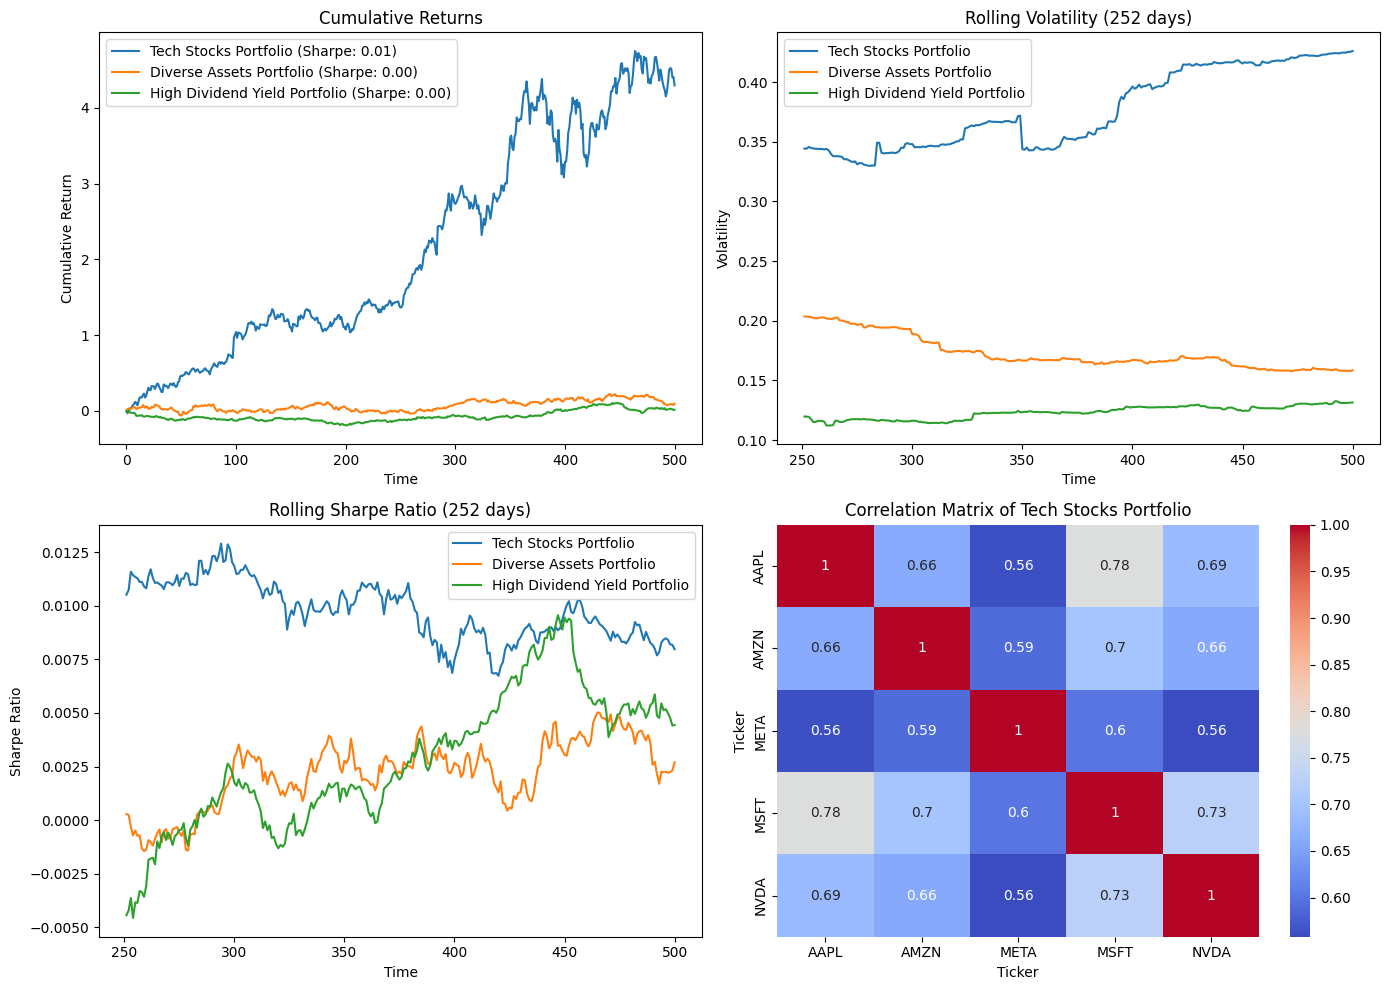

                       Portfolio  Volatility  Sharpe Ratio  Max Drawdown
0          Tech Stocks Portfolio    0.387040      0.009269     -0.388699
1       Diverse Assets Portfolio    0.181849      0.001106     -1.823285
2  High Dividend Yield Portfolio    0.125805      0.000146    -46.096734


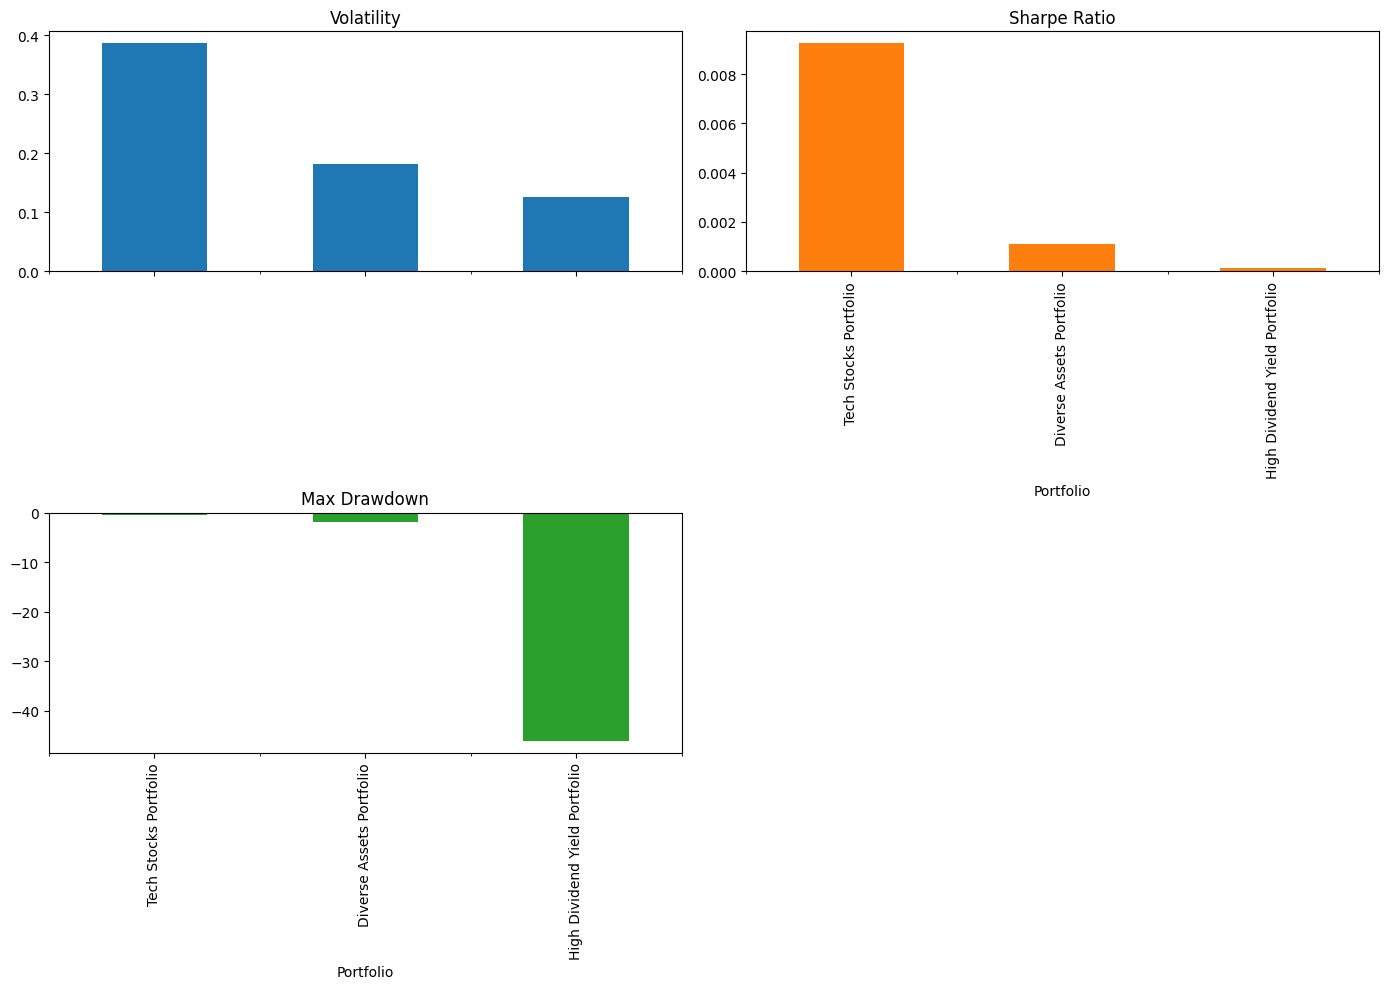

In [5]:
import os
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define function to calculate VaR and CVaR
def calculate_var(returns, confidence_level=0.95):
    mean = np.mean(returns)
    std_dev = np.std(returns)
    z_score = stats.norm.ppf(confidence_level)
    var = mean + z_score * std_dev
    return var

def calculate_cvar(returns, confidence_level=0.95):
    var = calculate_var(returns, confidence_level)
    cvar = returns[returns <= var].mean()
    return cvar

# Define function for scenario analysis
def scenario_analysis(portfolio_weights, scenarios):
    results = {}
    for scenario, returns in scenarios.items():
        portfolio_return = np.sum(portfolio_weights * returns.mean()) * 252
        portfolio_volatility = np.sqrt(np.dot(portfolio_weights.T, np.dot(returns.cov() * 252, portfolio_weights)))
        results[scenario] = (portfolio_return, portfolio_volatility)
    return results

# Define function for backtesting (including cumulative returns, volatility, Sharpe ratio, and max drawdown)
def backtest_portfolio(weights, returns, risk_free_rate=0.01):
    # Calculate portfolio returns
    portfolio_returns = returns

    # Calculate cumulative returns (starting from 1)
    cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

    # Annualized volatility
    volatility = np.std(portfolio_returns) * np.sqrt(252)

    # Adjust risk-free rate to daily if necessary
    daily_risk_free_rate = (1 + risk_free_rate)**(1/252) - 1
    sharpe_ratio = (np.mean(portfolio_returns) - daily_risk_free_rate) / volatility

    # Calculate max drawdown
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    return cumulative_returns, volatility, sharpe_ratio, max_drawdown

# Define function for daily rebalancing
def daily_rebalance(weights, returns):
    daily_returns = []
    current_weights = weights.copy()
    for i in range(len(returns)):
        daily_return = np.dot(current_weights, returns.iloc[i])
        daily_returns.append(daily_return)
        current_weights = current_weights * (1 + returns.iloc[i])
        current_weights /= np.sum(current_weights)
    return np.array(daily_returns)

# Portfolio selection
portfolios = {
    "Tech Stocks Portfolio": ['AAPL', 'MSFT', 'AMZN', 'META', 'NVDA'],
    "Diverse Assets Portfolio": ['AAPL', 'JNJ', 'GOOGL', 'XOM', 'JPM'],
    "High Dividend Yield Portfolio": ['T', 'VZ', 'KO', 'IBM', 'PFE']
}

# Download historical price data
start_date = "2021-01-01"
end_date = "2023-01-01"
data = {name: yf.download(assets, start=start_date, end=end_date)['Close'] for name, assets in portfolios.items()}

# Calculate daily returns
returns = {name: df.pct_change().dropna() for name, df in data.items()}

# Number of portfolios to simulate
num_portfolios = 10000

# Risk-free rate (for Sharpe ratio)
risk_free_rate = 0.01

optimal_portfolios = {}

for portfolio_name, assets in portfolios.items():
    results = np.zeros((4, num_portfolios))
    weights_record = []
    daily_risk_free_rate = (1 + risk_free_rate)**(1/252) - 1
    for i in range(num_portfolios):
        weights = np.random.random(len(assets))
        weights /= np.sum(weights)

        portfolio_return = np.sum(weights * returns[portfolio_name].mean()) * 252
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns[portfolio_name].cov() * 252, weights)))
        sharpe_ratio = (portfolio_return - daily_risk_free_rate) / portfolio_volatility

        results[0,i] = portfolio_return
        results[1,i] = portfolio_volatility
        results[2,i] = sharpe_ratio
        results[3,i] = weights.mean()
        weights_record.append(weights)

    max_sharpe_idx = np.argmax(results[2])
    optimal_weights = weights_record[max_sharpe_idx]
    optimal_portfolios[portfolio_name] = optimal_weights

    print(f"{portfolio_name} Weights: {optimal_weights}")

# Risk Assessment: VaR and CVaR
for portfolio_name, weights in optimal_portfolios.items():
    portfolio_returns = returns[portfolio_name].mean(axis=1)
    var = calculate_var(portfolio_returns)
    cvar = calculate_cvar(portfolio_returns)
    print(f"{portfolio_name} Value at Risk (VaR): {var}")
    print(f"{portfolio_name} Conditional Value at Risk (CVaR): {cvar}")

# Scenario Analysis for all portfolios
scenarios = ['Bull Market', 'Bear Market', 'Stagnant Market']

for portfolio_name, optimal_weights in optimal_portfolios.items():
    portfolio_returns = returns[portfolio_name]
    scenario_returns = {
        'Bull Market': portfolio_returns * 1.2,
        'Bear Market': portfolio_returns * 0.8,
        'Stagnant Market': portfolio_returns
    }
    results_scenario = scenario_analysis(optimal_weights, scenario_returns)
    print(f"Scenario Analysis Results for {portfolio_name}:")
    for scenario, result in results_scenario.items():
        print(f"{scenario}: Return = {result[0]:.2f}, Volatility = {result[1]:.2f}")

# Backtesting with rebalancing
end_date_backtest = "2025-01-01"
backtest_data = {name: yf.download(assets, start=end_date, end=end_date_backtest)['Close'] for name, assets in portfolios.items()}
backtest_returns = {name: df.pct_change().dropna() for name, df in backtest_data.items()}

# Initialize plot
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

portfolio_metrics = []

for portfolio_name, weights in optimal_portfolios.items():
    rebalanced_returns = daily_rebalance(weights, backtest_returns[portfolio_name])
    cumulative_returns, volatility, sharpe_ratio, max_drawdown = backtest_portfolio(weights, rebalanced_returns, risk_free_rate)

    # Plot cumulative returns
    ax[0, 0].plot(cumulative_returns, label=f"{portfolio_name} (Sharpe: {sharpe_ratio:.2f})")

    # Calculate rolling volatility
    rolling_volatility = pd.Series(rebalanced_returns).rolling(window=252).std() * np.sqrt(252)
    ax[0, 1].plot(rolling_volatility, label=portfolio_name)

    # Calculate rolling Sharpe ratio
    rolling_sharpe = (pd.Series(rebalanced_returns).rolling(window=252).mean() - daily_risk_free_rate) / rolling_volatility
    ax[1, 0].plot(rolling_sharpe, label=portfolio_name)

    # Collect portfolio metrics
    portfolio_metrics.append({
        "Portfolio": portfolio_name,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    })

    print(f"{portfolio_name} Backtest Volatility: {volatility}")
    print(f"{portfolio_name} Backtest Sharpe Ratio: {sharpe_ratio}")
    print(f"{portfolio_name} Max Drawdown: {max_drawdown}")

# Final plot adjustments
ax[0, 0].set_title('Cumulative Returns')
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Cumulative Return')
ax[0, 0].legend()

ax[0, 1].set_title('Rolling Volatility (252 days)')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Volatility')
ax[0, 1].legend()

ax[1, 0].set_title('Rolling Sharpe Ratio (252 days)')
ax[1, 0].set_xlabel('Time')
ax[1, 0].set_ylabel('Sharpe Ratio')
ax[1, 0].legend()

# Heatmap of correlation matrix
correlation_matrix = returns["Tech Stocks Portfolio"].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax[1, 1])
ax[1, 1].set_title('Correlation Matrix of Tech Stocks Portfolio')

plt.tight_layout()
plt.show()

# Display portfolio metrics
metrics_df = pd.DataFrame(portfolio_metrics)
print(metrics_df)

# Plot portfolio metrics for comparison
metrics_df.set_index("Portfolio").plot(kind="bar", subplots=True, layout=(2, 2), figsize=(14, 10), legend=False, title=["Volatility", "Sharpe Ratio", "Max Drawdown"])
plt.tight_layout()
plt.show()